In [1]:
import matplotlib.pyplot as plt
import scienceplots
import numpy as np
import scipy.optimize as optimize
from scipy.stats import linregress
import matplotlib as mpl

In [2]:
# RADIUS = (0.091 * 107.47 / 60.01) / 2
RADIUS = (14.35/2) * 10**-2
RADIUS_ERR = 0.01 / 100
N = 320
MU = 4 * np.pi * 10**-7
E = 1.60217662 * 10**-19
M = 9.10938356 * 10**-31


In [84]:
def B(I):
    return (8 * MU * N * I) / (np.sqrt(125) * RADIUS)

In [58]:
#LOW FREQUENCY
current = np.array([0.405, 0.2902, 0.260, 0.288, 0.359])
frequency = np.array([33.71, 24.30, 21.03, 23.13, 28.54]) * 10**6
frequency_err = np.array([0.34, 0.34, 0.34, 0.34, 0.34]) * 10**6
current_err = np.array([i * 0.02 for i in current])
current_err += 0.00825

In [71]:
i = 4
frequency[i] / (B(current[i]) / 2 / np.pi) / (E / 2 / M)

1.4163646067885198

In [ ]:
# x = np.array([B(i) for i in current])
# x_err = np.array([np.sqrt((B(x[i]) * RADIUS_ERR / RADIUS)**2 + (B(x[i]) / x[i] * current_err[i])**2) for i in range(len(current))])
# x = x / 2 / np.pi / (E / 2 / M)
# y = frequency
# y_err = frequency_err

In [5]:
def linear_f(x, m, b):
    return m * x + b

In [11]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('science')
plt.rcParams['figure.dpi']=220
plt.rc('text', usetex=False)
# plt.rc('text.latex', preamble=r'\usepackage{cmbright}')


In [36]:
def linear_fit(x, y, yerr):
    x = np.copy(x)
    y = np.copy(y)
    #https://q.utoronto.ca/courses/363859/files/32966656?module_item_id=6010287
    delta = len(x) * sum(x**2) - sum(x)**2
    m = (len(x) * sum(x*y) - sum(x) * sum(y)) / delta
    b = (sum(y) - m * sum(x)) / len(x)
    
    y_var_2 = ((1/ (len(x) - 2)) * sum((y - (b + m * x))**2))
    m_std = (y_var_2 * (len(x) / delta))**0.5
    b_std = (y_var_2 * (sum(x**2) / delta))**0.5
    
    r_2 = 1 - (len(x)-2) * y_var_2 / sum((y - np.mean(y))**2)
    
    chi_2 = sum((( y - (b + m * x)))**2 / yerr)
    reduced_chi_2 = chi_2 / (len(y) - 2)
    std_residuals = (sum((y - (b + m * x)) ** 2 ) / (len(x) - 2)) ** 0.5
        
    
    return (m, b, m_std, b_std, r_2, chi_2, reduced_chi_2, std_residuals)

In [31]:
def fit(x, y, y_err):
    param, cov = optimize.curve_fit(linear_f, x, y)
    m_err = np.sqrt(cov[0][0])
    b_err = np.sqrt(cov[1][1])

    chi_2 = np.sum((y - linear_f(x, *param)) ** 2 / y_err)
    reduced_chi_2 = chi_2 / (len(y) - 2)

    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean) ** 2)  # Total sum of squares
    ss_res = np.sum((y - (param[0] * x + param[1])) ** 2)  # Residual sum of squares
    r_squared = 1 - (ss_res / ss_tot)  # Coefficient of determination

    return (param, m_err, b_err, chi_2, reduced_chi_2, r_squared)

In [102]:
def plot(x, y, x_err, y_err, m, b, coil):
    # Plot the data
    plt.figure(figsize=(8,6))
    plt.errorbar(x, y, xerr=(x_err), yerr=y_err, 
                fmt='o', label='Data points', capsize=5)
    plt.plot(x, m * x + b, 'r-', label=f'Best Fit: v = {m:.2f}I + {b:.2f}')

    # Labels and title
    plt.xlabel("B (T)")
    plt.ylabel("Frequency (MHz)")
    plt.title(f"{coil} Coil: Magnetic Field vs Frequency")
    plt.legend()
    plt.grid()

    # Show the plot
    plt.savefig(f'{coil}.png')
    plt.show()

In [98]:
# def calculate_g(m, m_err):
#     g = m * 10**6 / (E / 4 / np.pi / M) / ((4/5) ** (3/2) * MU * N / RADIUS)
#     g_err = ((4 * np.pi * M / E * RADIUS / MU / N / ((4/5) ** (3/2)) * m_err * 10**6) ** 2 + (4 * np.pi * M / E * m / MU / N / ((4/5) ** (3/2)) * RADIUS_ERR * 10**6) ** 2) ** 0.5
#     return g, g_err

def calculate_g(m, m_err):
    g = m * 10**6 * 2 * np.pi * 2 * M / E
    g_err = m_err * 10**6 * 2 * np.pi * 2 * M / E
    return g, g_err


In [100]:
def everything(current, frequency, current_err, frequency_err, coil):
    param, m_err, b_err, chi_2, reduced_chi_2, r_squared = fit(current, frequency, frequency_err)
    m, b = param
    plot(current, frequency, current_err, frequency_err, m, b, coil)
    g, g_err = calculate_g(m, m_err)
    print(f"m = {m:.2f} ± {m_err:.2f}")
    print(f"b = {b:.2f} ± {b_err:.2f}")
    print(f"Reduced Chi^2 = {reduced_chi_2:.2f}")
    print(f"R^2 = {r_squared}")
    print(f"g = {g:.2f} ± {g_err:.2f}")
    

In [74]:
current = np.array([0.405, 0.2902, 0.260, 0.288, 0.359])
frequency = np.array([33.71, 24.30, 21.03, 23.13, 28.54]) #MHz
frequency_err = np.array([0.34, 0.34, 0.34, 0.34, 0.34]) #MHz
current_err = np.array([i * 0.02 for i in current])
current_err += 0.00825

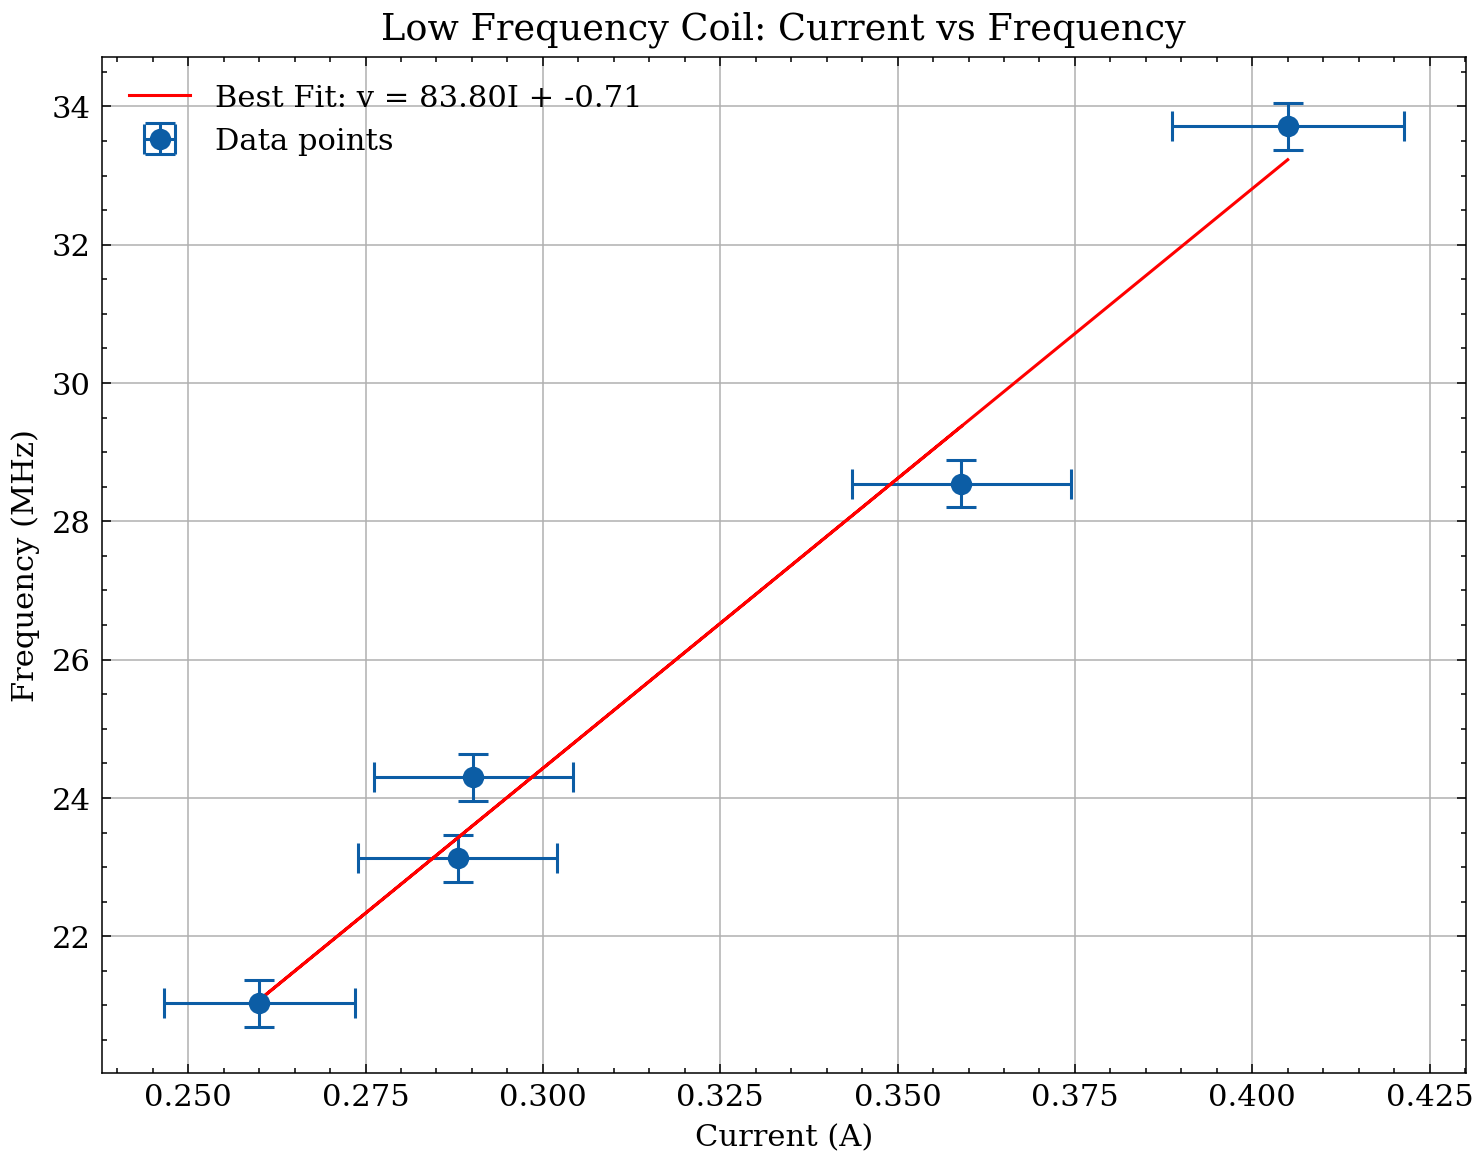

m = 83.80 ± 5.91
b = -0.71 ± 1.92
Reduced Chi^2 = 1.46
R^2 = 0.99
g = 1.49 ± 0.11


In [75]:
everything(current, frequency, current_err, frequency_err, "Low Frequency")

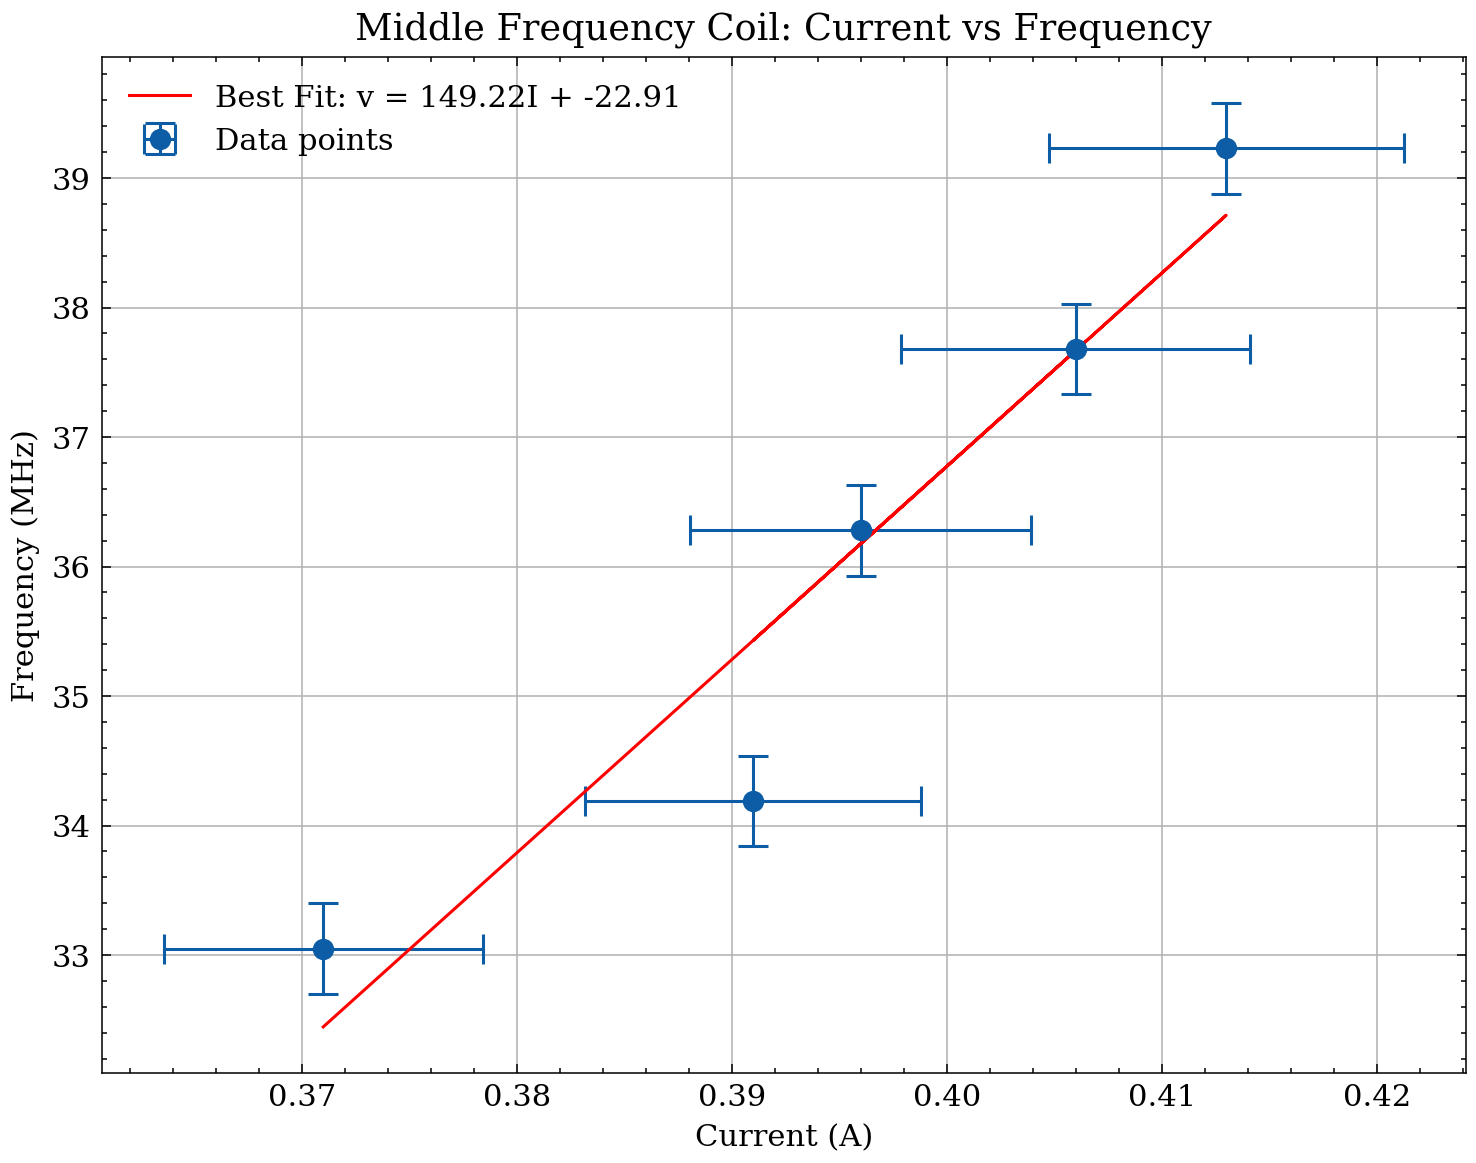

m = 149.22 ± 26.48
b = -22.91 ± 10.48
Reduced Chi^2 = 2.08
R^2 = 0.91
g = 2.66 ± 0.47


In [80]:
current = np.array([0.406, 0.396, 0.391, 0.413, 0.371])  # Current in A
frequency = np.array([37.68, 36.28, 34.19, 39.23, 33.05]) # Frequency in MHz
current_err = 0.02 * current  # 20% uncertainty in current
frequency_err = np.full_like(frequency, 0.35)  # Constant frequency uncertainty of 0.35 MHz
everything(current, frequency, current_err, frequency_err, "Middle Frequency")

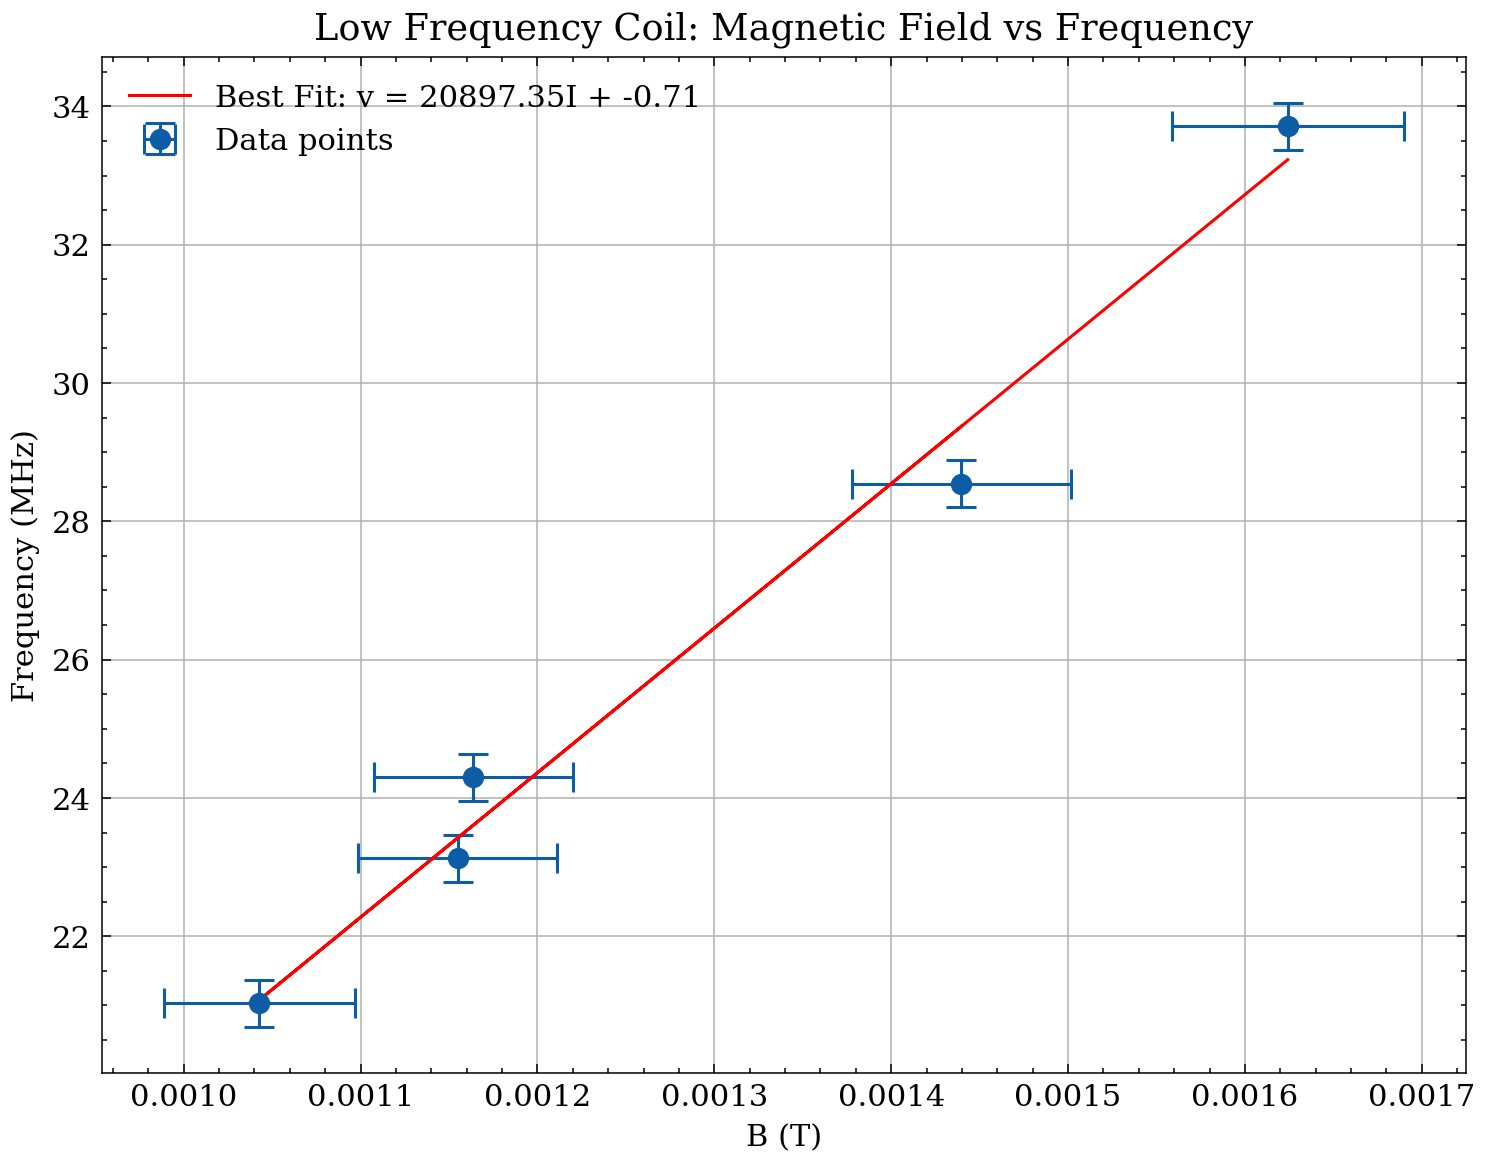

m = 20897.35 ± 1473.78
b = -0.71 ± 1.92
Reduced Chi^2 = 1.46
R^2 = 0.9852982156762196
g = 1.49 ± 0.11


In [103]:
current = np.array([0.405, 0.2902, 0.260, 0.288, 0.359])
frequency = np.array([33.71, 24.30, 21.03, 23.13, 28.54]) #MHz
frequency_err = np.array([0.34, 0.34, 0.34, 0.34, 0.34]) #MHz
current_err = np.array([i * 0.02 for i in current])
current_err += 0.00825

B_field = np.array([B(i) for i in current])
B_err = np.array([np.sqrt((B_field[i] * RADIUS_ERR / RADIUS)**2 + (B_field[i] / current[i] * current_err[i])**2) for i in range(len(current))])
# B = B / 2 / np.pi / (E / 2 / M)
everything(B_field, frequency, B_err, frequency_err, "Low Frequency")

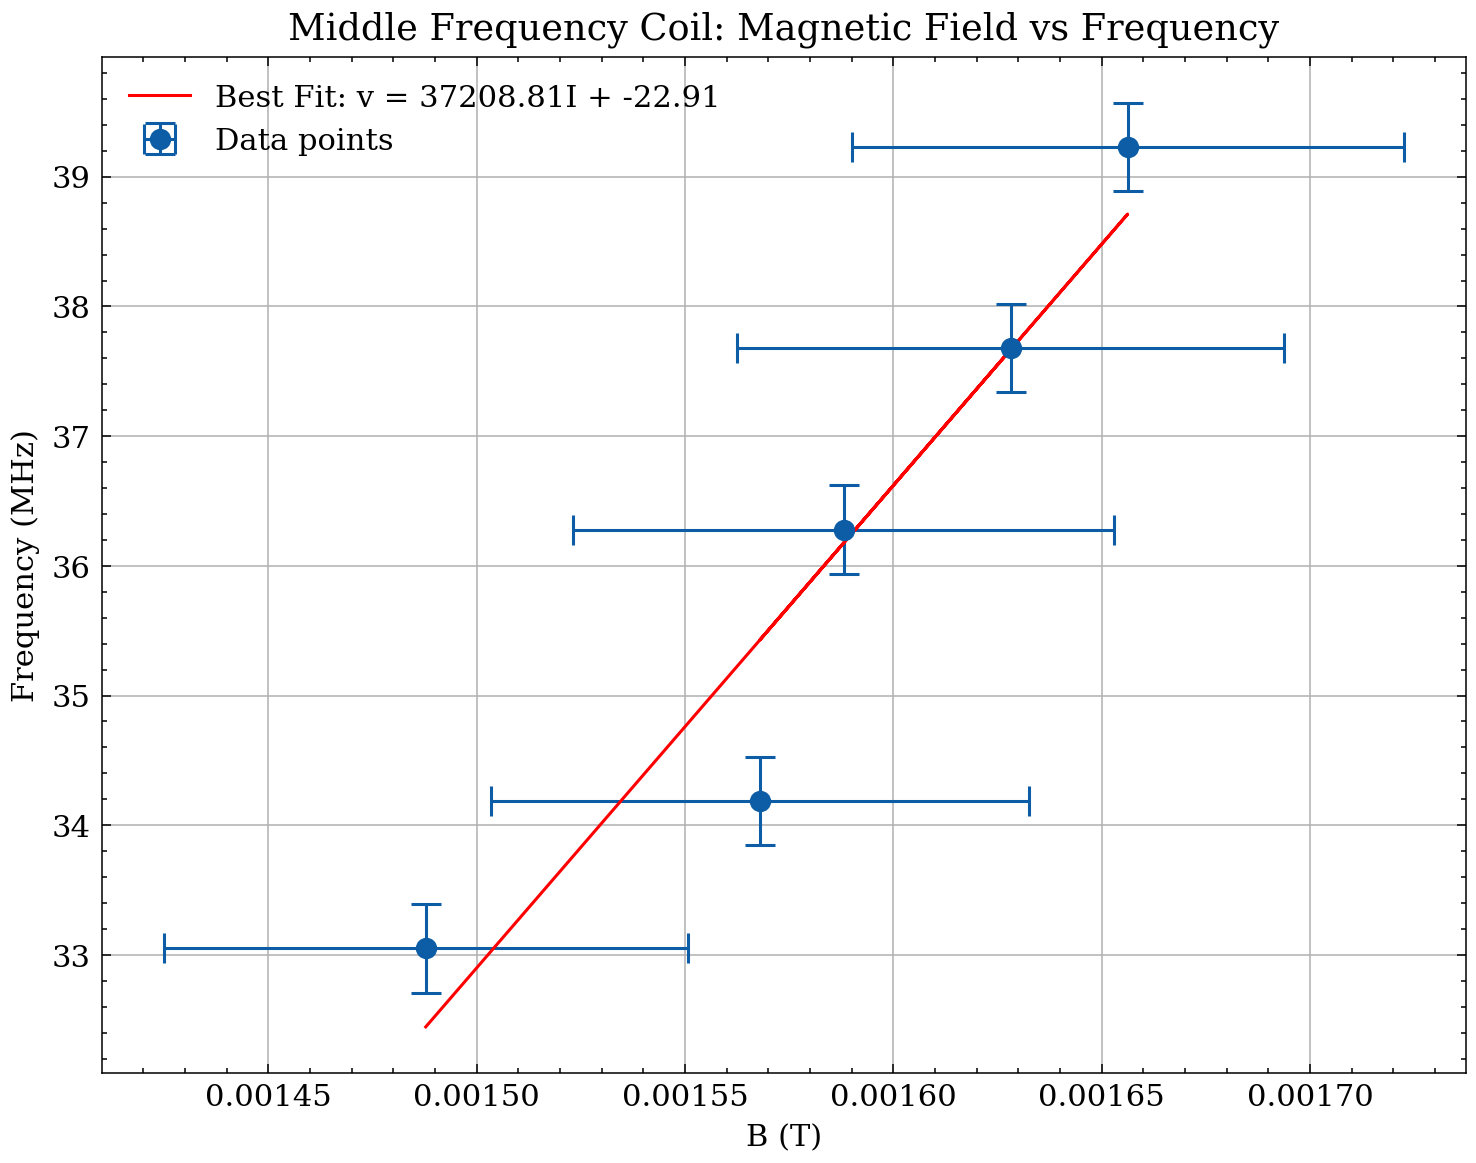

m = 37208.81 ± 6602.24
b = -22.91 ± 10.48
Reduced Chi^2 = 2.14
R^2 = 0.9136990430231887
g = 2.66 ± 0.47


In [104]:
current = np.array([0.406, 0.396, 0.391, 0.413, 0.371])  # Current in A
frequency = np.array([37.68, 36.28, 34.19, 39.23, 33.05]) # Frequency in MHz
frequency_err = np.array([0.34, 0.34, 0.34, 0.34, 0.34]) #MHz
current_err = np.array([i * 0.02 for i in current])
current_err += 0.00825

B_field = np.array([B(i) for i in current])
B_err = np.array([np.sqrt((B_field[i] * RADIUS_ERR / RADIUS)**2 + (B_field[i] / current[i] * current_err[i])**2) for i in range(len(current))])
# B = B / 2 / np.pi / (E / 2 / M)
everything(B_field, frequency, B_err, frequency_err, "Middle Frequency")